# Embeddings

Este notebook introduz o conceito fundamental de *embeddings*, que são representações vetoriais de dados complexos em um espaço de dimensão inferior. Exploraremos como gerar embeddings de texto utilizando modelos de linguagem modernos, como o BERTimbau, e aplicaremos esses vetores em tarefas práticas como cálculo de similaridade e busca semântica. Finalmente, visualizaremos a estrutura desses embeddings de alta dimensão utilizando técnicas de redução de dimensionalidade como t-SNE e UMAP.

### Introdução

Em aprendizado de máquina, um *embedding* é uma representação de dados complexos e de alta dimensionalidade em um espaço vetorial de dimensão inferior. O objetivo principal é capturar as relações semânticas ou estruturais inerentes aos dados brutos. Em vez de trabalhar com dados esparsos e categóricos (como palavras em um vocabulário), os modelos operam com vetores densos e contínuos.

Matematicamente, um embedding é uma função de mapeamento $f: X \rightarrow \mathbb{R}^d$, onde $X$ é o espaço dos dados de entrada (e.g., o conjunto de todas as palavras) e $\mathbb{R}^d$ é um espaço vetorial de dimensão $d$. A propriedade fundamental de um bom embedding é que a distância e a direção entre os vetores no espaço $\mathbb{R}^d$ correspondam a alguma noção de similaridade no espaço original $X$. Por exemplo, em embeddings de palavras, espera-se que as palavras "rei" e "rainha" estejam mais próximas no espaço vetorial do que as palavras "rei" e "carro".

Embora os embeddings de texto sejam os mais conhecidos, a técnica é aplicável a diversos domínios:

* **Embeddings de Grafos**: Nós em um grafo podem ser representados como vetores que capturam a topologia da rede (e.g., Node2Vec).
* **Embeddings de Imagens**: Modelos como Redes Neurais Convolucionais (CNNs) aprendem a extrair vetores de características (*feature vectors*) que representam o conteúdo semântico de uma imagem.
* **Embeddings Multimodais**: Representam diferentes tipos de dados (e.g., texto e imagem) em um mesmo espaço vetorial compartilhado, permitindo a comparação e a busca entre modalidades distintas (e.g., CLIP).

### Embeddings de Texto com Modelos Treinados

Modelos de linguagem modernos, especialmente os baseados na arquitetura Transformer, são extremamente eficazes na geração de embeddings de texto de alta qualidade. Esses modelos são pré-treinados em vastos corpora textuais, aprendendo a contextualizar palavras e sentenças. A plataforma Hugging Face disponibiliza acesso a milhares desses modelos pré-treinados.

Para nossos experimentos, utilizaremos o `BERTimbau`, uma versão do modelo BERT (Bidirectional Encoder Representations from Transformers) pré-treinada especificamente para o português do Brasil. Para simplificar a obtenção dos embeddings de sentenças inteiras, faremos uso da biblioteca `sentence-transformers`, que adapta modelos como o BERT para produzir representações vetoriais de sentenças de forma eficiente.

In [ ]:
# !pip install sentence-transformers torch scikit-learn matplotlib seaborn pandas umap-learn -q

In [ ]:
import torch
import numpy as np
from sentence_transformers import SentenceTransformer

In [ ]:
# Verifica se uma GPU está disponível e define o dispositivo
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Carregando um Modelo de Embeddings

A biblioteca `sentence-transformers` simplifica o processo de carregamento de modelos da Hugging Face e a subsequente geração de embeddings. Ao carregar o modelo `all-MiniLM-L6-v2`, a biblioteca utiliza uma arquitetura pré-configurada que já inclui a camada de *pooling* (geralmente *mean pooling*) no topo das saídas do modelo base. Isso permite agregar os vetores de saída de cada token em um único vetor de dimensão fixa que representa a sentença inteira.

In [ ]:
# Carrega o modelo pré-treinado para inglês
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(model_name, device=device)

print(f"Dimensão do embedding: {model.get_sentence_embedding_dimension()}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Dimensão do embedding: 384


In [ ]:
# Gera os embeddings para a frase de exemplo
sentence_embeddings = model.encode("This is an example sentence for embedding.")

print(f"Shape dos embeddings: {sentence_embeddings.shape}")

Shape dos embeddings: (384,)


In [ ]:
# Cria algumas sentenças de exemplo em inglês
sentences = [
    "Natural language processing has advanced greatly.",
    "Artificial intelligence is transforming the world.",
    "What is the capital of France?",
    "Paris is the most populated city in France."
]

sentence_embeddings = model.encode(sentences)

print(f"Shape da matriz de embeddings: {sentence_embeddings.shape}")
print(f"Embedding da primeira sentença:\n{sentence_embeddings[0][:10]}...")

Shape da matriz de embeddings: (4, 384)
Embedding da primeira sentença:
[ 0.04121822 -0.02944721  0.05479697 -0.02735754  0.04046019  0.01450551
 -0.06343079  0.04330898 -0.0713152   0.03568192]...


### Aplicações de Embeddings

Com as sentenças representadas como vetores, podemos realizar operações matemáticas para quantificar suas relações semânticas.

#### Cálculo de Similaridade Semântica

A similaridade de cosseno é uma métrica frequentemente utilizada para medir a similaridade entre dois vetores em um espaço de alta dimensão. Ela calcula o cosseno do ângulo entre os vetores, resultando em um valor que varia de -1 (exatamente opostos) a 1 (exatamente iguais), onde 0 indica ortogonalidade.

A fórmula da similaridade de cosseno entre dois vetores $A$ e $B$ é:

$$\text{similarity}(A, B) = \cos(\theta) = \frac{A \cdot B}{\|A\| \|B\|} = \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^{n} A_i^2} \sqrt{\sum_{i=1}^{n} B_i^2}}$$

Valores próximos de 1 indicam alta similaridade semântica.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Exemplo 1: Sentenças semanticamente similares
embedding1 = model.encode(["What is the capital of the United Kingdom?"])
embedding2 = model.encode(["London is the main city in the UK."])
similarity_score = cosine_similarity(embedding1, embedding2)[0][0]
print(f"Similaridade (Capital of UK vs London): {similarity_score:.4f}")

Similaridade (Capital of UK vs London): 0.6046


In [ ]:
# Exemplo 2: Sentenças semanticamente diferentes
embedding3 = model.encode(["Cats are popular pets."])
embedding4 = model.encode(["Quantum physics is a complex field."])
similarity_score_2 = cosine_similarity(embedding3, embedding4)[0][0]
print(f"Similaridade (Cats vs Quantum Physics): {similarity_score_2:.4f}")

Similaridade (Cats vs Quantum Physics): 0.0438


#### Busca Semântica

A busca semântica supera as limitações da busca por palavras-chave. Em vez de buscar correspondências exatas de termos, um sistema de busca semântica encontra documentos que são semanticamente relevantes para uma consulta, mesmo que não compartilhem as mesmas palavras.

O processo é direto:
1.  **Indexação**: Todo o corpus de documentos é pré-processado e convertido em vetores de embedding, que são armazenados em um banco de dados vetorial ou em memória.
2.  **Consulta**: A consulta do usuário é convertida no mesmo formato de embedding.
3.  **Recuperação**: O vetor da consulta é comparado com todos os vetores do corpus (usando a similaridade de cosseno), e os documentos mais similares são retornados.

In [ ]:
sentences = [
    "Government unveils new education reform plan.",
    "Senators clash over digital surveillance legislation.",
    "Elections in Europe mark historic voter turnout.",
    "AI startup releases open-source multimodal model.",
    "Quantum processor achieves record computational speed.",
    "Hackers target major bank in ransomware attack.",
    "Global markets rebound after week of volatility.",
    "Central bank raises rates to combat inflation.",
    "Tech stocks lead gains in morning trading session.",
    "Scientists confirm discovery of Earth-like exoplanet.",
    "New vaccine shows promise against emerging virus.",
    "Researchers achieve milestone in clean energy fusion.",
    "International film festival celebrates women directors.",
    "Museum opens interactive exhibit on digital art.",
    "City launches public program to promote urban cycling."
]

In [ ]:
sentence_embeddings = model.encode(sentences)

print(f"Shape da matriz de embeddings: {sentence_embeddings.shape}")

Shape da matriz de embeddings: (15, 384)


In [ ]:
# Consulta
query = "Planets similar to Earth"
query_embedding = model.encode([query])

# Recuperação: Calcula a similaridade de cosseno entre a consulta e todas as sentenças do corpus
similarities = cosine_similarity(query_embedding, sentence_embeddings)[0]

In [ ]:
# Encontra as k sentenças mais similares
k = 2
top_k_indices = np.argsort(similarities)[::-1][:k]

print(f"Consulta: '{query}'\n")
print(f"Top {k} sentenças mais similares no corpus:")
for index in top_k_indices:
    print(f"  - {sentences[index]} (Score: {similarities[index]:.4f})")

Consulta: 'Planets similar to Earth'

Top 2 sentenças mais similares no corpus:
  - Scientists confirm discovery of Earth-like exoplanet. (Score: 0.5536)
  - Researchers achieve milestone in clean energy fusion. (Score: 0.0720)


### Visualização de Embeddings com Redução de Dimensionalidade

Os embeddings gerados pelo modelo possuem 384 dimensões, tornando sua visualização direta impossível. Para inspecionar a estrutura do espaço de embeddings, utilizamos algoritmos de redução de dimensionalidade não-linear, como t-SNE e UMAP. O objetivo é projetar os dados em um espaço 2D ou 3D, preservando ao máximo as relações de vizinhança do espaço original.

#### t-SNE (t-Distributed Stochastic Neighbor Embedding)

O t-SNE é um algoritmo que modela as distâncias entre pontos de dados como probabilidades. No espaço de alta dimensão, ele constrói uma distribuição de probabilidade sobre pares de pontos, de forma que pontos similares tenham uma alta probabilidade de serem escolhidos. Em seguida, ele tenta otimizar um mapeamento para o espaço de baixa dimensão que minimize a divergência de Kullback-Leibler entre as distribuições de probabilidade dos dois espaços. O t-SNE é particularmente eficaz em revelar a estrutura de clusters locais.

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Aplica o t-SNE para reduzir a dimensionalidade para 2 componentes
# A perplexidade pode ser ajustada; um valor entre 5 e 50 é comum.
# Como temos poucas amostras, um valor baixo é mais apropriado.
tsne = TSNE(n_components=2, perplexity=5, random_state=42, init='random', learning_rate=200)
embeddings_2d_tsne = tsne.fit_transform(sentence_embeddings)

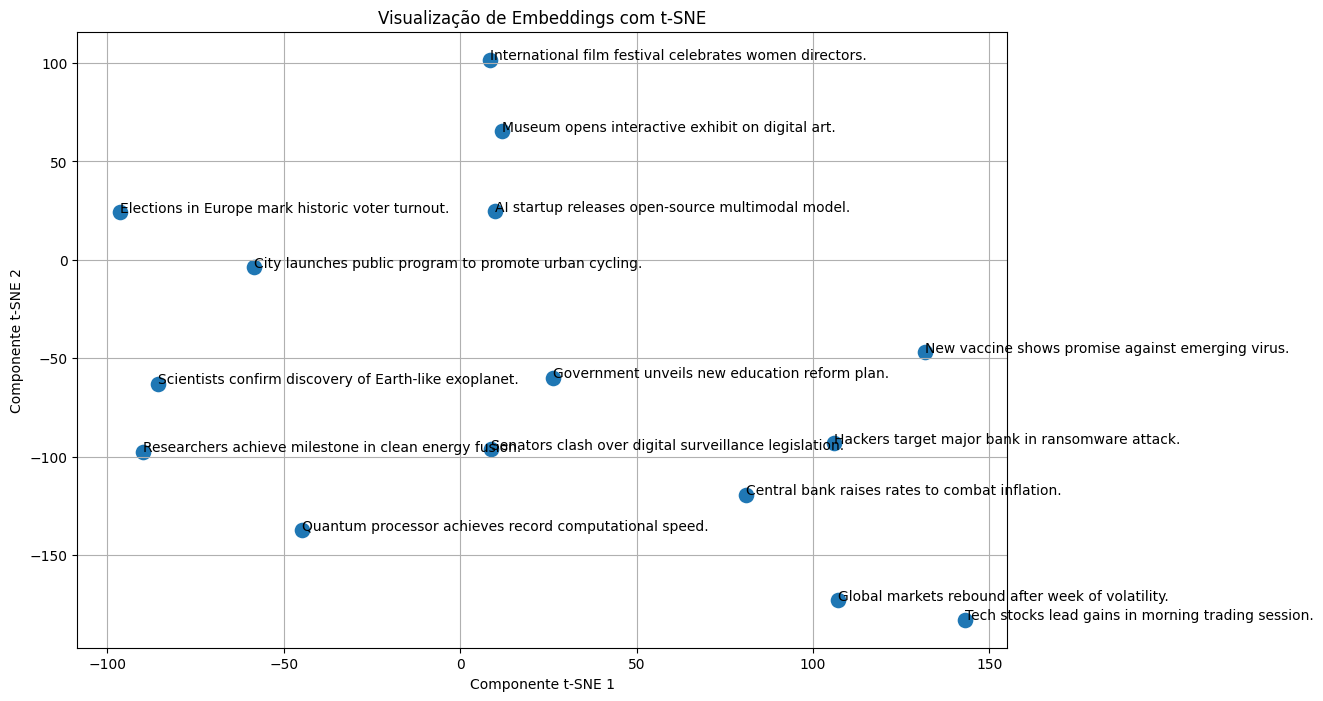

In [ ]:
# Cria um DataFrame para a plotagem
df_tsne = pd.DataFrame({
    'x': embeddings_2d_tsne[:, 0],
    'y': embeddings_2d_tsne[:, 1],
    'sentence': sentences
})

# Plota os resultados
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_tsne, x='x', y='y', s=150)

# Adiciona anotações aos pontos
for i in range(df_tsne.shape[0]):
    plt.text(
        df_tsne.x[i],
        df_tsne.y[i],
        df_tsne.sentence[i],
        ha='left',
        size=10,
        color='black',
        alpha=1.0,
        weight='normal'
    )

plt.title('Visualização de Embeddings com t-SNE')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.grid(True)
plt.show()